In [1]:
!unzip '/content/heart+disease.zip'

Archive:  /content/heart+disease.zip
  inflating: Index                   
  inflating: WARNING                 
  inflating: ask-detrano             
  inflating: bak                     
  inflating: cleve.mod               
  inflating: cleveland.data          
   creating: costs/
  inflating: costs/Index             
  inflating: costs/heart-disease.README  
  inflating: costs/heart-disease.cost  
  inflating: costs/heart-disease.delay  
  inflating: costs/heart-disease.expense  
  inflating: costs/heart-disease.group  
  inflating: heart-disease.names     
  inflating: hungarian.data          
  inflating: long-beach-va.data      
  inflating: new.data                
  inflating: processed.cleveland.data  
  inflating: processed.hungarian.data  
  inflating: processed.switzerland.data  
  inflating: processed.va.data       
  inflating: reprocessed.hungarian.data  
  inflating: switzerland.data        


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# Load and combine data

In [3]:
def load_multi_subset(file_paths):
    column_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg","thalach", "exang", "oldpeak", "slope", "ca", "thal", "Target"]
    combined_data = pd.DataFrame()
    for file_path in file_paths:
        subset = pd.read_csv(file_path, header=None, names=column_names, na_values="?")
        combined_data = pd.concat([combined_data, subset], ignore_index=True)
    print("DataSet shape :", combined_data.shape)
    return combined_data

file_paths = [
    "processed.cleveland.data",
    "processed.hungarian.data",
    "processed.switzerland.data",
    "processed.va.data"]


# Load and preprocess data
data = load_multi_subset(file_paths)
data.head()

DataSet shape : (920, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,Target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [4]:
(data.isnull().sum()/data.shape[0])*100

,0
age,0.000000
sex,0.000000
cp,0.000000
trestbps,6.413043
chol,3.260870
fbs,9.782609
restecg,0.217391
thalach,5.978261
exang,5.978261
oldpeak,6.739130


# Dropping columns >50% missing values

In [5]:
data.drop(["ca", "thal"], axis=1, inplace=True)

In [6]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,Target
count,920.000000,920.000000,920.000000,861.000000,890.000000,830.000000,918.000000,865.000000,865.000000,858.000000,611.000000,920.000000
mean,53.510870,0.789130,3.250000,132.132404,199.130337,0.166265,0.604575,137.545665,0.389595,0.878788,1.770867,0.995652
std,9.424685,0.408148,0.930969,19.066070,110.780810,0.372543,0.805827,25.926276,0.487941,1.091226,0.619256,1.142693
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,1.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,175.000000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,223.000000,0.000000,0.000000,140.000000,0.000000,0.500000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,268.000000,0.000000,1.000000,157.000000,1.000000,1.500000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


(array([203.,   0.,   0.,   0.,   0., 345.,   0.,   0.,   0.,  63.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

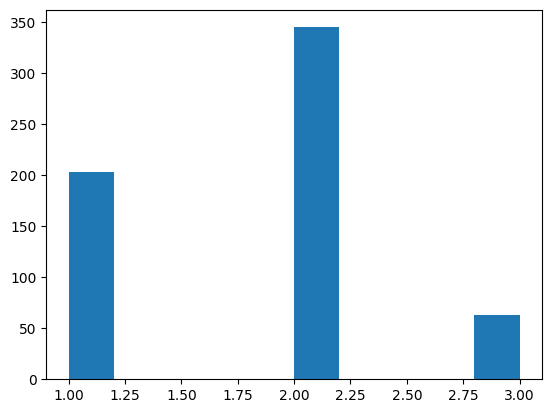

In [7]:
import matplotlib.pyplot as plt
plt.hist(data["slope"])

<Axes: >

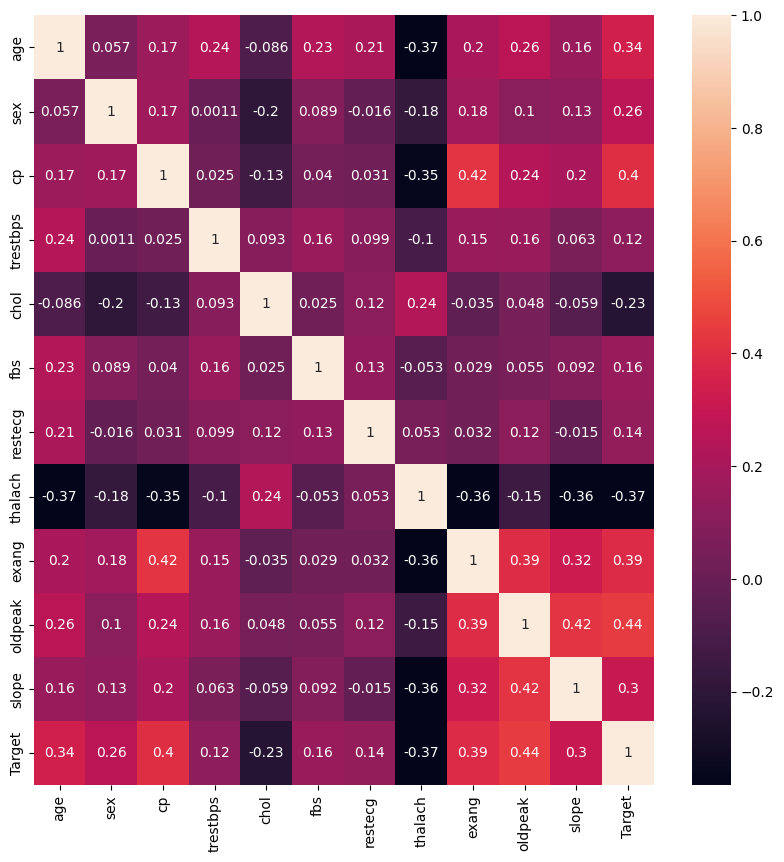

In [8]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True)

In [9]:
data["slope"].fillna(data["slope"].mode()[0], inplace=True)

In [10]:
(data.isnull().sum()/data.shape[0])*100

,0
age,0.000000
sex,0.000000
cp,0.000000
trestbps,6.413043
chol,3.260870
fbs,9.782609
restecg,0.217391
thalach,5.978261
exang,5.978261
oldpeak,6.739130


In [11]:
data.dtypes

,0
age,float64
sex,float64
cp,float64
trestbps,float64
chol,float64
fbs,float64
restecg,float64
thalach,float64
exang,float64
oldpeak,float64


In [12]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,Target
count,920.000000,920.000000,920.000000,861.000000,890.000000,830.000000,918.000000,865.000000,865.000000,858.000000,920.000000,920.000000
mean,53.510870,0.789130,3.250000,132.132404,199.130337,0.166265,0.604575,137.545665,0.389595,0.878788,1.847826,0.995652
std,9.424685,0.408148,0.930969,19.066070,110.780810,0.372543,0.805827,25.926276,0.487941,1.091226,0.516007,1.142693
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,1.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,175.000000,0.000000,0.000000,120.000000,0.000000,0.000000,2.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,223.000000,0.000000,0.000000,140.000000,0.000000,0.500000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,268.000000,0.000000,1.000000,157.000000,1.000000,1.500000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


In [13]:
data["restecg"].unique()

array([ 2.,  0.,  1., nan])

In [14]:
data["fbs"].unique()

array([ 1.,  0., nan])

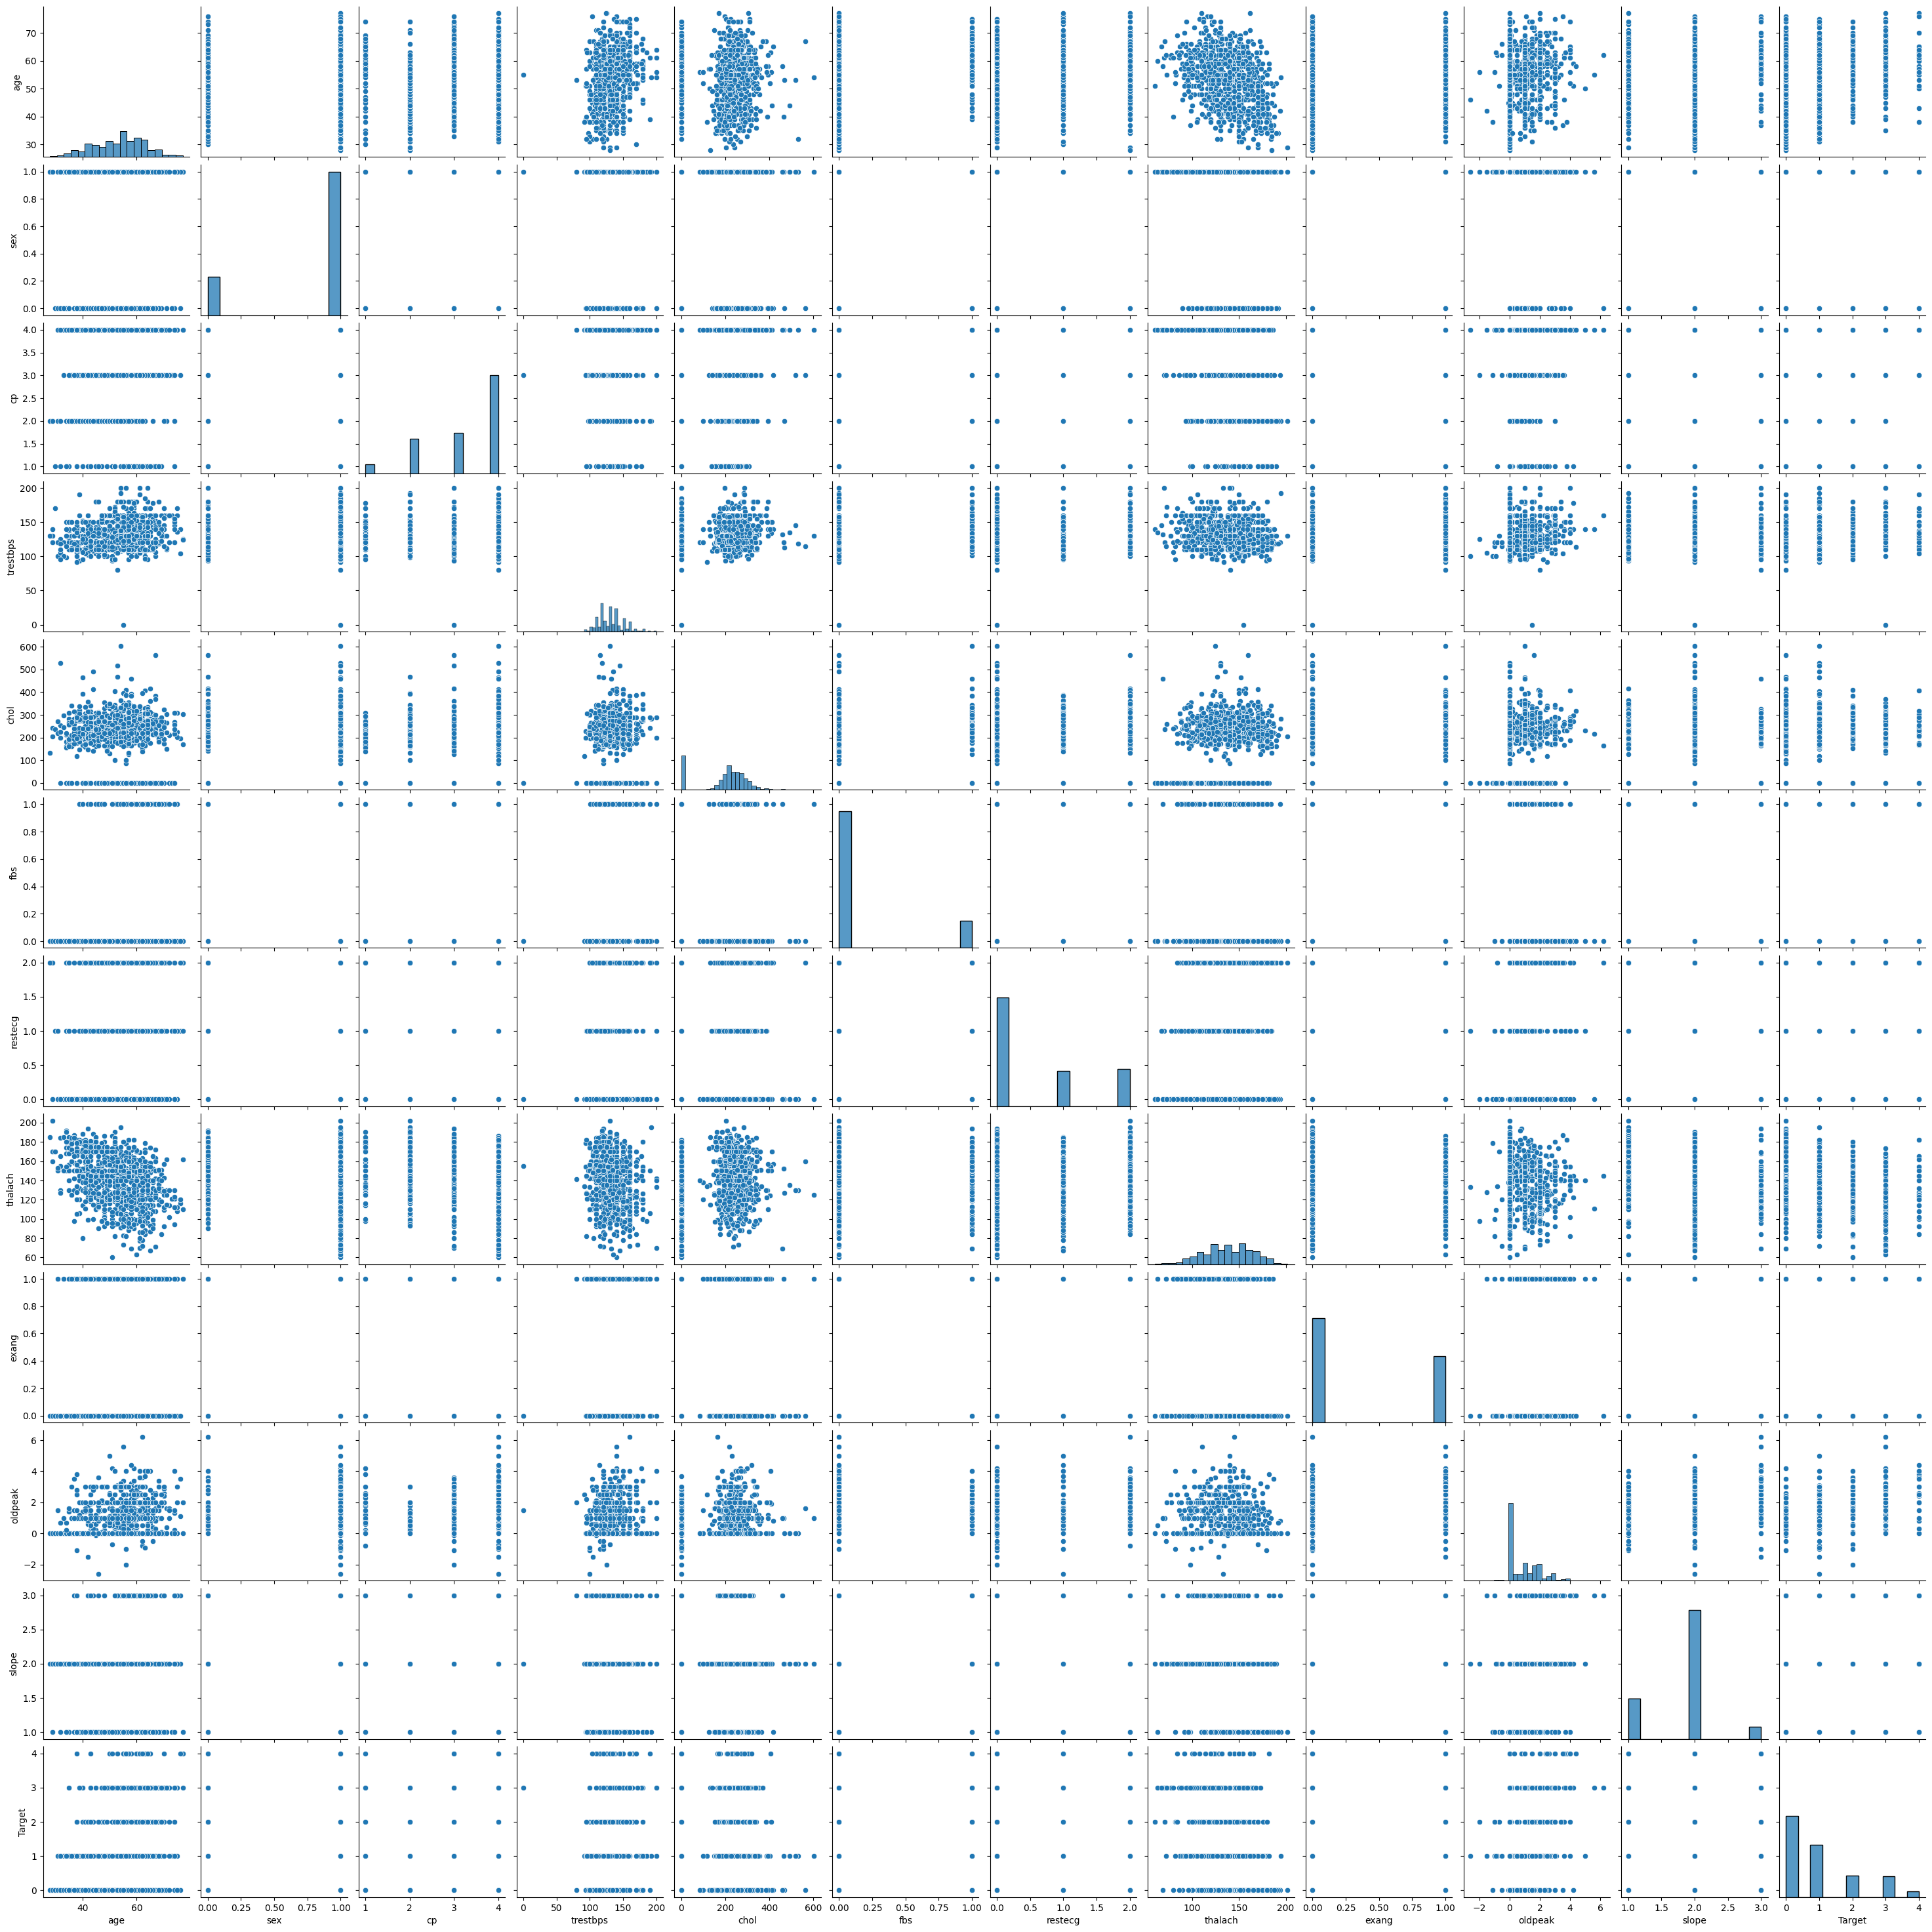

In [15]:
import seaborn as sns
sns.pairplot(data)

In [16]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'Target'],
      dtype='object')

In [17]:
data["thalach"].fillna(data["thalach"].mean(), inplace=True)
data["trestbps"].fillna(data["trestbps"].mean(), inplace=True)
data["chol"].fillna(data["chol"].mean(), inplace=True)
data["oldpeak"].fillna(data["oldpeak"].mean(), inplace=True)

data["fbs"].fillna(data["fbs"].mode()[0], inplace=True)
data["restecg"].fillna(data["restecg"].mode()[0], inplace=True)
data["exang"].fillna(data["exang"].mode()[0], inplace=True)

In [18]:
(data.isnull().sum()/data.shape[0])*100

,0
age,0.0
sex,0.0
cp,0.0
trestbps,0.0
chol,0.0
fbs,0.0
restecg,0.0
thalach,0.0
exang,0.0
oldpeak,0.0


# Preprocess data

In [19]:
def preprocess_data(data):
    X = data.drop("Target", axis=1)
    y = data["Target"]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

X, y = preprocess_data(data)

# Apply SMOTE for balancing

In [20]:
def apply_smote(X, y):
    print("Before SMOTE: ", y.value_counts())
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print("\n")
    print("After SMOTE: ", y_resampled.value_counts())
    return X_resampled, y_resampled

X_resampled, y_resampled = apply_smote(X, y)


Before SMOTE:  Target
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64


After SMOTE:  Target
0    411
2    411
1    411
3    411
4    411
Name: count, dtype: int64


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, test_size=0.2, random_state=42)


# Train multiple models

In [22]:
def train_models(X_train, y_train):
    models = {
        "Logistic Regression": LogisticRegression(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBClassifier": XGBClassifier()
    }
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model
    return trained_models

print("Training Multiple models")
models = train_models(X_train, y_train)

Training Multiple models


# Evaluate models

In [23]:
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = []
    for name, model in models.items():
        y_test_pred = model.predict(X_test)

        y_test_prob = (
            model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
        )

        test_metrics = {
            "Model": name,
            "Dataset": "Test",
            "Accuracy": accuracy_score(y_test, y_test_pred),
            "Precision": precision_score(y_test, y_test_pred, average="weighted"),
            "Recall": recall_score(y_test, y_test_pred, average="weighted"),
            "F1 Score": f1_score(y_test, y_test_pred, average="weighted"),
        }

        if y_test_prob is not None and y_test_prob.ndim > 1:
            test_metrics["ROC-AUC"] = roc_auc_score(
                y_test, y_test_prob, multi_class="ovr", average="weighted"
            )

        results.extend([test_metrics])

        # Print test metrics
        print(f"\nModel: {name} (Test)")
        print("__________________________________")
        print(f"Accuracy: {test_metrics['Accuracy']:.2f}")
        print(f"Precision: {test_metrics['Precision']:.2f}")
        print(f"Recall: {test_metrics['Recall']:.2f}")
        print(f"F1 Score: {test_metrics['F1 Score']:.2f}")
        if "ROC-AUC" in test_metrics:
            print(f"ROC-AUC: {test_metrics['ROC-AUC']:.2f}")
        print(classification_report(y_test, y_test_pred, zero_division=0))

    return pd.DataFrame(results)

# Example Usage
results = evaluate_models(models, X_train, y_train, X_test, y_test)
print("\nSummary of Model Performance:")
print("__________________________________")
print(results)



Model: Logistic Regression (Test)
__________________________________
Accuracy: 0.51
Precision: 0.51
Recall: 0.51
F1 Score: 0.51
ROC-AUC: 0.79
              precision    recall  f1-score   support

           0       0.67      0.76      0.71        82
           1       0.42      0.33      0.37        82
           2       0.39      0.43      0.41        82
           3       0.45      0.41      0.43        83
           4       0.60      0.65      0.62        82

    accuracy                           0.51       411
   macro avg       0.51      0.51      0.51       411
weighted avg       0.51      0.51      0.51       411


Model: Random Forest (Test)
__________________________________
Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1 Score: 0.77
ROC-AUC: 0.95
              precision    recall  f1-score   support

           0       0.74      0.76      0.75        82
           1       0.59      0.57      0.58        82
           2       0.79      0.77      0.78        82
           3  

# Feature importance

In [24]:
def feature_importance(model, X_columns):
    if hasattr(model, "feature_importances_"):
        importance_df = pd.DataFrame({
            "Feature": X_columns,
            "Importance": model.feature_importances_
        }).sort_values(by="Importance", ascending=False)
        print("\nFeature Importances:")
        print("__________________________________")
        print(importance_df)
        return importance_df
    else:
        print("Feature importance is not available for this model.")

for name, model in models.items():
    if isinstance(model, (RandomForestClassifier, GradientBoostingClassifier, XGBClassifier)):
        print("___________________________")
        print(f"\n{name} Feature Importances:")
        feature_importance(model, data.drop("Target", axis=1).columns)

___________________________

Random Forest Feature Importances:

Feature Importances:
__________________________________
     Feature  Importance
9    oldpeak    0.155878
0        age    0.146134
7    thalach    0.132919
4       chol    0.131839
3   trestbps    0.111708
2         cp    0.091490
6    restecg    0.075095
10     slope    0.051081
8      exang    0.045928
1        sex    0.032129
5        fbs    0.025799
___________________________

Gradient Boosting Feature Importances:

Feature Importances:
__________________________________
     Feature  Importance
9    oldpeak    0.204777
2         cp    0.157947
0        age    0.122401
4       chol    0.117917
7    thalach    0.108517
3   trestbps    0.098712
6    restecg    0.061303
8      exang    0.041761
10     slope    0.039569
1        sex    0.031734
5        fbs    0.015362
___________________________

XGBClassifier Feature Importances:

Feature Importances:
__________________________________
     Feature  Importance
2       

# Compare with baseline metrics

In [25]:
def compare_with_baseline(results, baseline_metrics):
    print("\nBaseline Metrics:")
    print("__________________________________")
    for metric, value in baseline_metrics.items():
        print(f"{metric}: {value:.2f}")
    print("\nModel Performance Comparison:")
    print("__________________________________")
    print(results)

baseline_metrics = {
        "Accuracy": 0.83,
        "Precision": 0.83
    }
compare_with_baseline(results, baseline_metrics)


Baseline Metrics:
__________________________________
Accuracy: 0.83
Precision: 0.83

Model Performance Comparison:
__________________________________
                 Model Dataset  Accuracy  Precision    Recall  F1 Score  \
0  Logistic Regression    Test  0.513382   0.505273  0.513382  0.507129   
1        Random Forest    Test  0.773723   0.771907  0.773723  0.772621   
2    Gradient Boosting    Test  0.673966   0.669534  0.673966  0.670758   
3        XGBClassifier    Test  0.761557   0.758701  0.761557  0.759166   

    ROC-AUC  
0  0.789288  
1  0.949651  
2  0.893602  
3  0.931661  


# Select best model based on a specific metric

In [26]:
def select_best_model(results):
    best_model = results.sort_values(by="Accuracy", ascending=False).iloc[0]
    print(f"\nBest Model: {best_model['Model']}")
    print("__________________________________")
    print(f"Accuracy: {best_model['Accuracy']:.2f}")
    print(f"Precision: {best_model['Precision']:.2f}")
    print(f"Recall: {best_model['Recall']:.2f}")
    print(f"F1 Score: {best_model['F1 Score']:.2f}")
    if "ROC-AUC" in best_model:
        print(f"ROC-AUC: {best_model['ROC-AUC']:.2f}")
    return best_model

best_model = select_best_model(results)


Best Model: Random Forest
__________________________________
Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1 Score: 0.77
ROC-AUC: 0.95


# Hyperparameter Tuning

In [27]:
from sklearn.model_selection import GridSearchCV
param_grid = {"n_estimators":[50, 100, 150],
              "criterion":["gini", "entropy"],
              "max_depth":[5,10,15],
              "min_samples_split":[2, 3, 4],
              "min_samples_leaf":[1, 2, 3]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring="accuracy", verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END crite

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=2)

In [28]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [29]:
model = RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=150)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76        82
           1       0.59      0.54      0.56        82
           2       0.79      0.77      0.78        82
           3       0.85      0.83      0.84        83
           4       0.90      0.98      0.94        82

    accuracy                           0.78       411
   macro avg       0.77      0.78      0.78       411
weighted avg       0.77      0.78      0.78       411

